In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import numpy as np
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer  
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


#setting display options
sns.set(style='whitegrid')
pd.set_option("display.max_columns", 36)

#load data
#data = pd.read_csv('/content/hotel_bookings.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv('/content/drive/My Drive/Data/hotel_bookings.csv')

In [6]:
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [7]:
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [0]:
#Replacing the missing values:
#agent: If no agency is given, booking was most likely made without one.
#company: If none given, its most likely private

nan_replacement = {"children": 0.0, "country": "Unknown", "agent": 0, "company":0}

data_cln = data.fillna(nan_replacement)

# "meal" contains values "Undefines", which is equal to SC
data_cln['meal'].replace("Undefined", "SC", inplace=True)

#Some rows contain entries with 0 adults, 0 children and 0 babies.
#I'm dropping these entries with no guests.
zero_guests = list(data_cln.loc[data_cln["adults"] + data_cln["children"] + data_cln["babies"]==0].index)

data_cln.drop(data_cln.index[zero_guests], inplace=True)



In [9]:
data_cln.shape

(119210, 32)

##EDA

In [0]:
#After cleaning, separate Resort and City hotel
# To know the actual visitor numbers, only bookings that were not canceled are included

rh = data_cln.loc[(data_cln["hotel"] == "Resort Hotel") & (data_cln["is_canceled"]==0)]
ch = data_cln.loc[(data_cln["hotel"] == "City Hotel") & (data_cln["is_canceled"]==0)]

In [11]:
rh

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,Resort Hotel,0,212,2017,August,35,31,2,8,2,1.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,143.0,0.0,0,Transient,89.75,0,0,Check-Out,2017-09-10
40056,Resort Hotel,0,169,2017,August,35,30,2,9,2,0.0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250.0,0.0,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10
40057,Resort Hotel,0,204,2017,August,35,29,4,10,2,0.0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250.0,0.0,0,Transient,153.57,0,3,Check-Out,2017-09-12
40058,Resort Hotel,0,211,2017,August,35,31,4,10,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40.0,0.0,0,Contract,112.80,0,1,Check-Out,2017-09-14


###Where do the guests come from?

In [0]:
#Get Number of actual guests by country
country_data = pd.DataFrame(data_cln.loc[data_cln["is_canceled"]==0]["country"].value_counts())


In [0]:
test = pd.DataFrame(data_cln.loc[data_cln['is_canceled']==0]["arrival_date_week_number"].value_counts())

In [0]:
test["week_no"] = test.index


In [15]:
print(test)

    arrival_date_week_number  week_no
33                      2071       33
34                      1995       34
32                      1877       32
30                      1839       30
28                      1799       28
21                      1793       21
29                      1747       29
31                      1744       31
27                      1679       27
42                      1675       42
35                      1664       35
15                      1641       15
38                      1621       38
17                      1620       17
41                      1609       41
18                      1609       18
39                      1591       39
20                      1563       20
23                      1549       23
19                      1534       19
13                      1532       13
22                      1530       22
44                      1525       44
26                      1525       26
24                      1475       24
43          

In [16]:
test.sort_values(by='week_no' )

,arrival_date_week_number,week_no
1,692,1
2,821,2
3,983,3
4,980,4
5,960,5
6,1122,6
7,1419,7
8,1421,8
9,1385,9
10,1405,10


In [17]:
print(country_data)

     country
PRT    20977
GBR     9668
FRA     8468
ESP     6383
DEU     6067
..       ...
CYM        1
MAC        1
BDI        1
SLE        1
ZMB        1

[166 rows x 1 columns]


In [0]:
country_data.rename(columns={"country":"Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data['Number of Guests'] / total_guests*100, 2)
country_data["country"] = country_data.index

In [19]:

print(country_data)

     Number of Guests  Guests in % country
PRT             20977        27.97     PRT
GBR              9668        12.89     GBR
FRA              8468        11.29     FRA
ESP              6383         8.51     ESP
DEU              6067         8.09     DEU
..                ...          ...     ...
CYM                 1         0.00     CYM
MAC                 1         0.00     MAC
BDI                 1         0.00     BDI
SLE                 1         0.00     SLE
ZMB                 1         0.00     ZMB

[166 rows x 3 columns]


In [20]:
#Pie Plot

fig = px.pie(country_data, 
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition = "inside", textinfo="value + percent + label")
fig.show()

In [21]:
#showing on map
guest_map = px.choropleth(country_data, 
                          locations= country_data.index,
                          color=country_data["Guests in %"],
                          hover_name = country_data.index,
                          color_continuous_scale = px.colors.sequential.Plasma,
                          title= "Home Country of guests")
guest_map.show()

People from all over the world are staying in these two hotels. Most guests are from portugal and other europian countries in Europe

##How much do guests pay for a room per night?
Both hotels are different room types and different meal arrangements. Seasonal factors are also important. So the prices vary a lot.
Since no currency info is given, but portugal is part of the European Monetary unnion, Assuming all prices are EUR

In [22]:
print(rh['adr'])

0          0.00
1          0.00
2         75.00
3         75.00
4         98.00
          ...  
40055     89.75
40056    202.27
40057    153.57
40058    112.80
40059     99.06
Name: adr, Length: 28927, dtype: float64


In [23]:
#Counting adults and children as paying guests only, not babies.
rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])
ch["adr_pp"] = ch["adr"] / (ch['adults']+ch['children'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
print(rh["adr_pp"])

0          0.000000
1          0.000000
2         75.000000
3         75.000000
4         49.000000
            ...    
40055     29.916667
40056    101.135000
40057     76.785000
40058     56.400000
40059     49.530000
Name: adr_pp, Length: 28927, dtype: float64


In [25]:
print("""From all non-canceled bookings, across all room types and meals, the average prices are::
Resort Hotel : {:.2f} Euros per night and person.
City Hotel: {:.2f} Euros per night and person."""
.format(rh["adr_pp"].mean(), ch['adr_pp'].mean()))

From all non-canceled bookings, across all room types and meals, the average prices are::
Resort Hotel : 47.49 Euros per night and person.
City Hotel: 59.27 Euros per night and person.


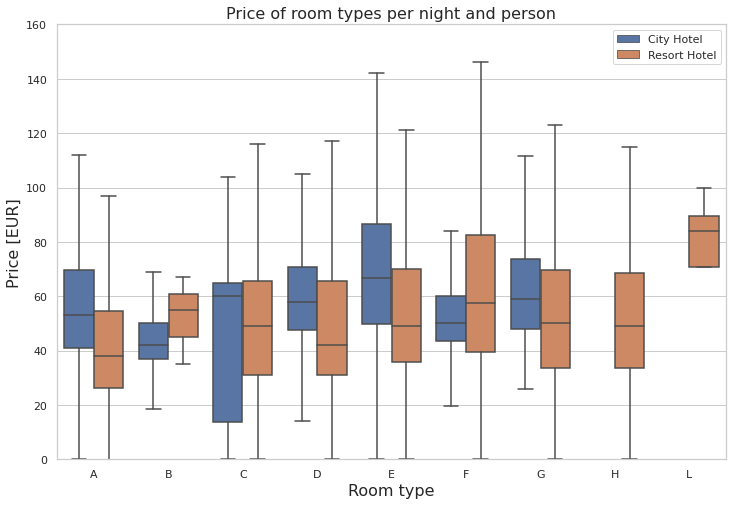

In [27]:
#Normalize price per night (adr):
data_cln['adr_pp'] = data_cln["adr"]/(data_cln["adults"]+ data_cln["children"])
data_guests = data_cln.loc[data_cln["is_canceled"]==0] #Only actual guests
room_prices = data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

#Boxplot
plt.figure(figsize=(12,8))
sns.boxplot(x="reserved_room_type", y="adr_pp",
            hue="hotel",
            data=room_prices,
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0,160)
plt.show()

This figure shows the average price per room, depending on its type and the standard deviation.

Note that due to data anonymization rooms with the same type letter may not necessarily be the same across hotels.

##How does the price per night vary over the year?

To keep it simple, I'm using the average price per night and person, regardless of the room, type and meal

In [0]:
#Grab data:
room_prices_monthy = data_cln[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
room_prices_monthy["arrival_date_month"]= pd.Categorical(room_prices_monthy["arrival_date_month"], categories=ordered_months, ordered=True)
                                                         

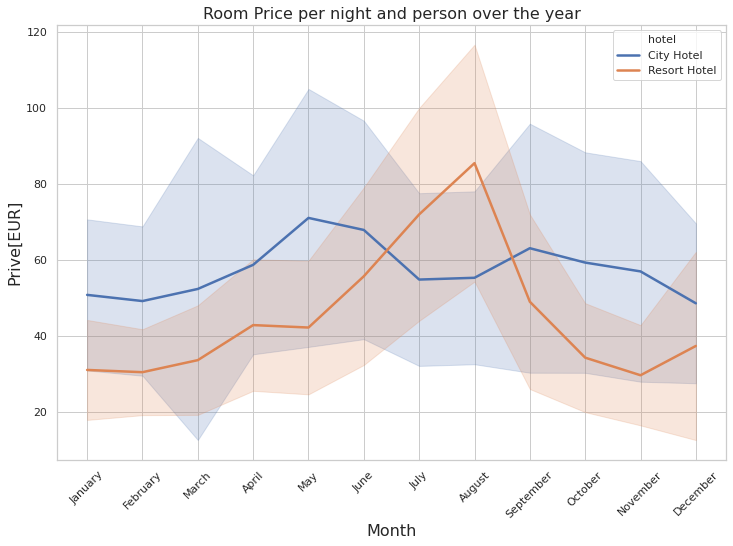

In [30]:
#Barplot with standard deviation:
plt.figure(figsize=(12,8))
sns.lineplot(x="arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_monthy,
             hue_order=["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5,2.5))
plt.title("Room Price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Prive[EUR]", fontsize=16)
plt.show()

This clearly shows that the prices in the Resort hotel are much higher during the summer(no surpise here).
The price of the city hotel varies less and is most expensive during spring and autumn.

###Which months are most busy?

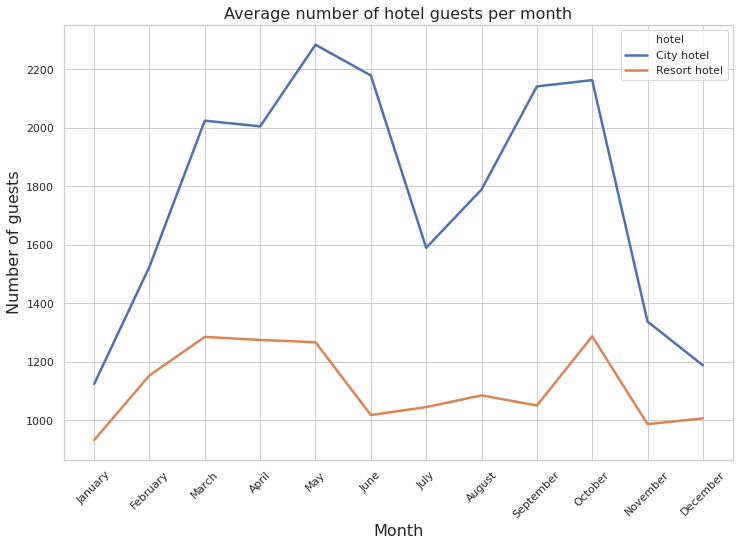

In [31]:
# Create a DateFrame with the relevant data:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

The city hotel has more guests spring and autumn, when the prices are also high in July and August there are less visitors, although prices are lower.

Guest numbers for the Resort hotel go down slightly from June to September, which is a also the prices are highest.

Both hotels have the fewest guests during the winter

###How long do people stay at the hotels?

In [32]:
#create a dataframe with the relevant data:

rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
num_nights_res = list(rh["total_nights"].value_counts().index)

In [0]:
num_bookings_res = list(rh['total_nights'].value_counts())

In [35]:
print(rh["total_nights"])

0         0
1         0
2         1
3         1
4         2
         ..
40055    10
40056    11
40057    14
40058    14
40059    14
Name: total_nights, Length: 28927, dtype: int64


In [36]:
print(num_nights_res)
print(num_bookings_res)

[1, 2, 7, 3, 4, 5, 6, 10, 14, 8, 9, 0, 11, 12, 13, 21, 15, 28, 25, 16, 17, 22, 35, 18, 19, 42, 30, 29, 45, 46, 56, 60, 69, 38, 23]
[6579, 4488, 4434, 3828, 3321, 1899, 1205, 699, 630, 509, 408, 371, 240, 89, 75, 35, 23, 22, 14, 12, 11, 7, 5, 5, 4, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1]


In [0]:
rel_bookings_res =  rh["total_nights"].value_counts()/sum(num_bookings_res)*100

In [38]:
rel_bookings_res

1     22.743458
2     15.514917
7     15.328240
3     13.233311
4     11.480624
5      6.564801
6      4.165658
10     2.416428
14     2.177896
8      1.759602
9      1.410447
0      1.282539
11     0.829675
12     0.307671
13     0.259273
21     0.120994
15     0.079510
28     0.076054
25     0.048398
16     0.041484
17     0.038027
22     0.024199
35     0.017285
18     0.017285
19     0.013828
42     0.010371
30     0.006914
29     0.006914
45     0.003457
46     0.003457
56     0.003457
60     0.003457
69     0.003457
38     0.003457
23     0.003457
Name: total_nights, dtype: float64

In [0]:
res_nights=pd.DataFrame({
    "hotel":"Resort Hotel",
    "num_nights":num_nights_res,
    "rel_num_bookings": rel_bookings_res
})

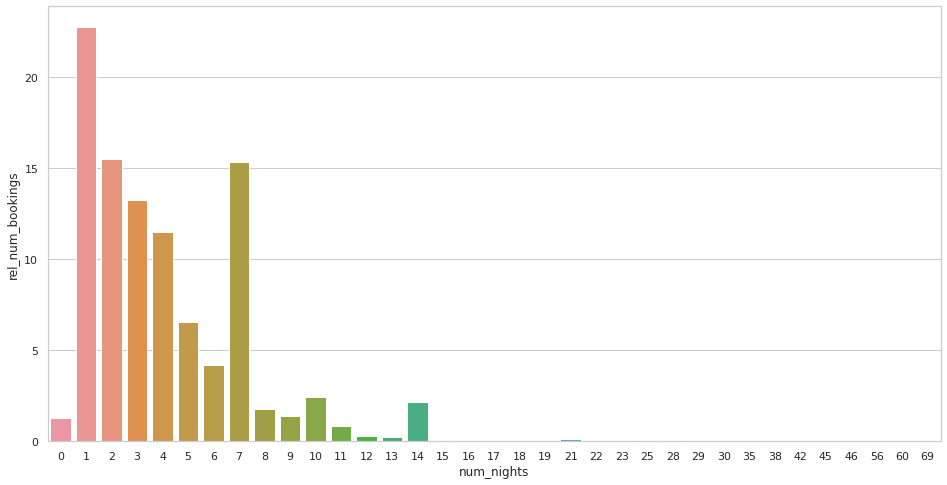

In [40]:
plt.figure(figsize=(16,8))
sns.barplot(x="num_nights", y="rel_num_bookings", data=res_nights)

For the city hotel there is a clear preference for 1-4 nights.
For the resort hotel, 1-4 nights are also often booled, but 7 nights is their nest choice.

##Bookings by market segment

In [41]:
#total bookings per market segment (inc. canceled)
segments = data_cln["market_segment"].value_counts()

#pie plot
fig = px.pie(segments, 
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

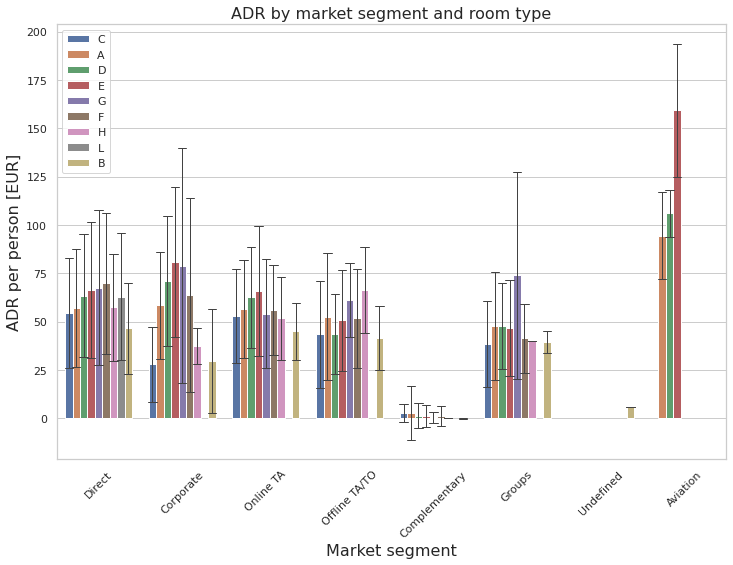

In [42]:
#price per night (adr) and person based on booking and room.
#show figure

plt.figure(figsize=(12,8))
sns.barplot(
    x="market_segment",
    y="adr_pp",
    hue="reserved_room_type",
    data=data_cln,
    ci="sd",
    errwidth=1,
    capsize=0.1
)
plt.title("ADR by market segment and room type",fontsize=16)
plt.xlabel("Market segment",fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show()

On average, gorups get the best prices and Airlines pay approximately twice as much.
what are possible reasons for the high prices paid by airlines.

In [0]:
Airline_data = data_cln.loc[data_cln["market_segment"]=="Aviation"][["is_canceled",
                                                                     "adults",
                                                                     "lead_time",
                                                                     "adr_pp",]].describe()
                                                    

In [44]:
Airline_data

,is_canceled,adults,lead_time,adr_pp
count,235.000000,235.000000,235.00000,235.000000
mean,0.221277,1.012766,4.47234,100.270979
std,0.415992,0.112503,4.61629,20.376689
min,0.000000,1.000000,0.00000,0.000000
25%,0.000000,1.000000,1.00000,95.000000
50%,0.000000,1.000000,3.00000,95.000000
75%,0.000000,1.000000,6.00000,110.000000
max,1.000000,2.000000,23.00000,193.500000


In [0]:
Non_Airline_data = data_cln.loc[data_cln["market_segment"] != "Aviation"][["is_canceled",
                                                                                "adults",
                                                                                "lead_time",
                                                                                "adr_pp",]].describe()

In [46]:
Non_Airline_data

,is_canceled,adults,lead_time,adr_pp
count,118975.000000,118975.000000,118975.000000,118975.000000
mean,0.371061,1.860878,104.306031,55.036835
std,0.483091,0.574499,106.888885,29.017596
min,0.000000,0.000000,0.000000,-3.190000
25%,0.000000,2.000000,18.000000,37.440000
50%,0.000000,2.000000,69.000000,49.500000
75%,1.000000,2.000000,161.000000,66.000000
max,1.000000,55.000000,737.000000,2700.000000




1.   Lead time for bookings from aviation is very short: Mean 4 days vs 104 days for other bookings
2.   Airlines NEED a place for their crews to stay.
3.   Airline personel usually gets one room per person - more total rooms required compared to families.



How many bookings were canceled?

In [0]:
#absolute cancelations:
total_cancelations = data_cln["is_canceled"].sum()
rh_cancelations = data_cln.loc[data_cln["hotel"]=="Resort Hotel"]["is_canceled"].sum()
ch_cancelations = data_cln.loc[data_cln['hotel']=="City Hotel"]["is_canceled"].sum()


In [48]:
#as percent
rel_cancel = total_cancelations / data_cln.shape[0]*100
rh_rel_cancel = rh_cancelations / data_cln.loc[data_cln["hotel"]=="Resort Hotel"].shape[0]*100
ch_rel_cancel = ch_cancelations / data_cln.loc[data_cln["hotel"]=="City Hotel"].shape[0]*100

print(f"Total bookings canceled: {total_cancelations:,}({rel_cancel:.0f}%)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,}({rh_rel_cancel:.0f} %)")
print(f'City hotel bookings canceled: {ch_cancelations:,}({ch_rel_cancel:.0f}%)')


Total bookings canceled: 44,199(37%)
Resort hotel bookings canceled: 11,120(28 %)
City hotel bookings canceled: 33,079(42%)


In [0]:
#Create a DateFrame with the relevant data:
res_book_per_month = data_cln.loc[(data_cln["hotel"]=="Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = data_cln.loc[(data_cln["hotel"]=="Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = data_cln.loc[(data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = data_cln.loc[(data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({
    "Hotel" : "Resort Hotel",
    "Month" : list(res_book_per_month.index),
    "Bookings": list(res_book_per_month.values),
    "Cancelations" : list(res_cancel_per_month.values)
})

cty_cancel_data = pd.DataFrame({
    "Hotel" : "City Hotel",
    "Month" : list(cty_book_per_month.index),
    "Bookings": list(cty_book_per_month.values),
    "Cancelations" : list(cty_cancel_per_month.values)
})



In [50]:
cty_book_per_month

arrival_date_month
April        7469
August       8967
December     4114
February     4950
January      3730
July         8071
June         7885
March        6434
May          8221
November     4336
October      7594
September    7392
Name: hotel, dtype: int64

In [0]:
full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)


In [0]:
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"]/ full_cancel_data["Bookings"]*100

In [0]:
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

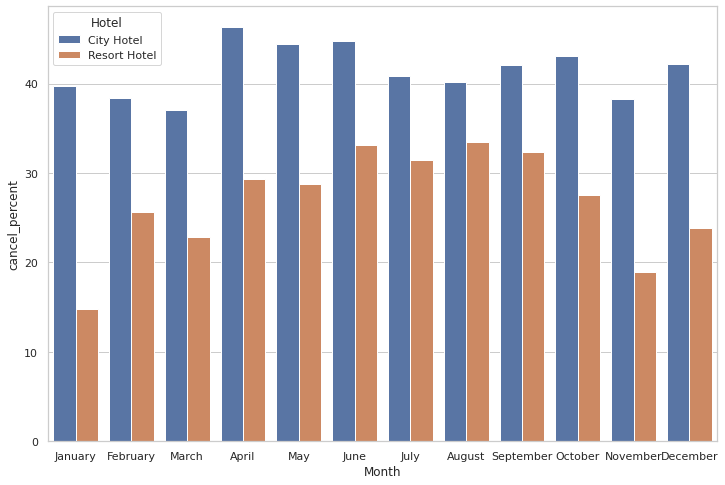

In [57]:
plt.figure(figsize=(12,8))
sns.barplot(x="Month", y="cancel_percent", hue="Hotel", hue_order=['City Hotel', "Resort Hotel"], data=full_cancel_data)


For the city hotel the relative number of cancelations is around 40 % throughout the year.
FOr the resort hotel it is highest in the summer and lowest during the winter.

###Predict cancelations

Which numerical features are most important?

In [58]:
cancel_corr = data.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

From the list it is apparent that lead_time, total of special requests, required car parking spaces, booking changes and previous cancelations are the 5 most important numerical features.

However, to predict whether or not a booking is canceld, the number of booking changes is a possible source of leakage, because this information can change over time.

I will also not include days in waiting list and arrival date year.

The most important feature to exclude is the reservation status.

In [59]:
data.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: reservation_status, dtype: int64

###Comparing diferent base models:

In [0]:
#manually choose columns to includ
#some columns are excluded to make the model more general and to prevent leakage


num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]



In [0]:
features = num_features + cat_features

In [0]:
X = data.drop(['is_canceled'], axis=1)[features]

In [0]:
y = data['is_canceled']

In [0]:
#preprocess numerical feats:
#for  most num cols, except the dates, 0 is the most logical choice as fill values
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

cat_transformer = Pipeline(steps=[
                                  ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                                  ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [66]:
#define models to test:

base_models = [('DT_model', DecisionTreeClassifier(random_state=42)),
               ('RF_model', RandomForestClassifier(random_state=42, n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42, n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

kfolds = 4 # 4 means 75% train, 25% validation

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

#Preprocessing, fitting, making predictions and scoring for every model:

for name, model in base_models:
    #pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)])
    
    #get cross validation score for each model:
    cv_results = cross_val_score(model_steps,
                                 X, y,
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    #output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuracy score : {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")
    

DT_model cross validation accuracy score : 0.8246 +/- 0.0016 (std) min: 0.8221, max: 0.8263


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



RF_model cross validation accuracy score : 0.8664 +/- 0.0012 (std) min: 0.8646, max: 0.8676
LR_model cross validation accuracy score : 0.7937 +/- 0.0012 (std) min: 0.792, max: 0.7952
XGB_model cross validation accuracy score : 0.8165 +/- 0.0016 (std) min: 0.8139, max: 0.8181


The RandomForest model performs best.
Some hyperparameter optimization, but the accuracy increase is minimal:

In [68]:
rf_model_enh = RandomForestClassifier(n_estimators=160,
                                      max_features=0.4,
                                      min_samples_split=2,
                                      n_jobs=-1,
                                      random_state=0)
split=KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe= Pipeline(steps=[('preprocessor', preprocessor),
                            (('model'), rf_model_enh)])
cv_results = cross_val_score(model_pipe, 
                             X, y,
                             cv=split,
                             scoring="accuracy",
                             n_jobs=-1)

#output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)

print(f"Enhanced RF model cross validation accuracy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Enhanced RF model cross validation accuracy score: 0.8681 +/- 0.0006 (std) min: 0.8673, max: 0.869


Evaluate Feature Importance.


In [70]:
#fit model (pipeline) so values can be accessed:
model_pipe.fit(X, y)

#Names of all (encoded) features are needed.
#get names of columns from One Hot Encoding:

onehot_columns = list(model_pipe.named_steps['preprocessor'].
                       named_transformers_['cat'].
                       named_steps['onehot'].
                       get_feature_names(input_features=cat_features))

#add num_features for full list.
#order must be as in definition of X where numm_feaures are firstL

feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names = feat_imp_list
)
feat_imp_df.head(10)

NameError: ignored

Looking at the three most important features:


1.   lead_time
2.   deposit_type
3.   adr




###Lead_time

In [0]:
#group data for lead time:

lead_cancel_data = data_cln.groupby("lead_time")["is_canceled"].describe()

#use only lead times with more than 10 bookings for graph:

lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"]>=10]

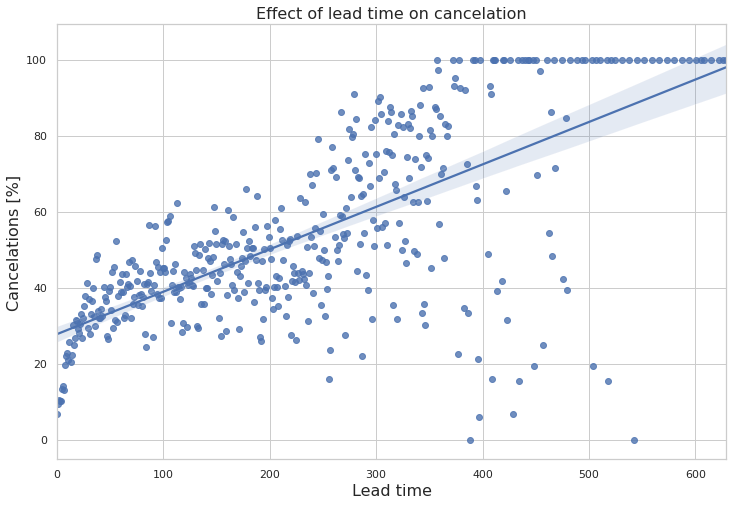

In [72]:
#show figure:
plt.figure(figsize=(12,8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()